In [1]:
#%% 
############# generating fake pore images 3D and extract network and geom #################

import porespy as ps
import matplotlib.pyplot as plt
import os
import numpy as np
import openpnm as op
import openpnm.models as mods
from openpnm.models import physics as pm
import pandas as pd


def n2_cal(pore_index,pore_occ):
    # cal of redundant loop
    # throats connected with pores that are all invaded by phase
    return (pore_occ[pore_index[0]] & 
            pore_occ[pore_index[1]])

def n3_cal(pore_index,pore_occ):
    # cal of isolated pore
    # throats connected with pores that are both not invaded by phase
    return not (pore_occ[pore_index[0]] | 
            pore_occ[pore_index[1]])



# generate 3D porous media image
ws = op.Workspace()
proj = ws.new_project()
np.random.seed(0)

im = ps.generators.blobs(shape=[200, 200, 200], 
                         porosity =0.3,blobiness=1)
print(f'the porosity is {ps.metrics.porosity(im)}')




the porosity is 0.2927585


In [2]:
# running snow algorithm to extract pore geometry information from network
snow = ps.networks.snow(
    im=im,
    boundary_faces=
    ['top', 'bottom'],
    voxel_size=2e-05)

# extracting network and geometry from snow simulation results
pn,geo = op.io.PoreSpy.import_data(snow)

# check the health of network
health = pn.check_network_health()
op.topotools.trim(network=pn, pores=health['trim_pores'])
print('the number of pores is {}.'.format(len(pn['pore.all'])))

# define phase and physics
air = op.phases.Air(network=pn)
water = op.phases.Water(network=pn)
phys_air = op.physics.Standard(network=pn, phase=air, geometry=geo)
phys_water = op.physics.Standard(network=pn, phase=water, geometry=geo)

# perform invasion flow simulation
ip = op.algorithms.InvasionPercolation(network=pn)
ip.setup(phase=air)
in_pores=pn.pores("top")
ip.set_inlets(pores=in_pores)
ip.run()


------------------------------------------------------------
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  878
Peaks after trimming saddle points:  656
Peaks after trimming nearby peaks:  656
------------------------------------------------------------
Extracting pore and throat information from image
100%|██████████| 773/773 [00:02<00:00, 337.10it/s]
the number of pores is 741.


In [3]:
def cal_phase_conn(pn,air):
    # calculate phase connectivity
    # input: pn, air
    # output: phase connectivity
    n1 = np.sum(air['pore.occupancy']*1)
    # air filled throat
    fill_t = np.where(air['throat.occupancy']==True)[0]
    # throat connected pore
    n2 = 0
    n3 = 0
    
    for index in fill_t:
        conn_pore = pn['throat.conns'][index]
        if n2_cal(conn_pore,air['pore.occupancy']):
            n2+=1
        
        if n3_cal(conn_pore,air['pore.occupancy']):
            n3+=1
    chi = n1-n2+n3
    
    return chi

In [4]:
occ_list = []
random_shuffle = 15
sat_list = [x for x in np.arange(0,1.1,0.03)]
for s in sat_list:
    shuffle_list = []
    occ_origin = ip.results(Snwp=s)
    shuffle_list.append(occ_origin)
    for _ in range(random_shuffle):
        occ = {}
        occ['pore.occupancy'] = np.random.permutation(occ_origin['pore.occupancy'])
        occ['throat.occupancy'] = np.random.permutation(occ_origin['throat.occupancy'])
        shuffle_list.append(occ)
    occ_list.append(shuffle_list)
    

In [5]:
#%%
############### relative perm simulation ###################
st = op.algorithms.StokesFlow(network=pn)
st.setup(phase=water)
# in boundary front water saturation is 1
st.set_value_BC(pores=pn.pores('top'), values=1)
st.set_value_BC(pores=pn.pores('bottom'), values=0)
st.run()
Q_abs_water = st.rate(pores=pn.pores('top'))

air.update(ip.results(Snwp=0.20))
val = np.amin(phys_water['throat.hydraulic_conductance'])/1000

### cal of relative k of water ###
phys_water.regenerate_models()  # Regenerate phys2 to reset any calculation done above
Q_water_list = []  # Initialize a list to hold data
phase_conn_list = []
sat_list_sim = []
#stokes flow for water
for sat_index in range(len(occ_list)):
    for occ_random in occ_list[sat_index]:
        # 1: Update air object with occupancy at given saturation
        air.update(occ_random)
        # 2: Overwrite water's hydraulic conductance in air-filled locations
        phys_water['throat.hydraulic_conductance'][air['throat.occupancy']] = val
        # 3: Re-run flow problem
        st.run()
        # 4: Compute flow through inlet phase and append to data
        Q_water_list.append(st.rate(pores=pn.pores('top')))
        phase_conn_list.append(cal_phase_conn(pn,air))
        sat_list_sim.append(sat_list[sat_index])
        phys_water.regenerate_models()

In [6]:
phys_water.regenerate_models()
phys_air.regenerate_models()
Q_air_list=[]
#stokes flow for air
st_a = op.algorithms.StokesFlow(network=pn)
st_a.setup(phase=air)
st_a.set_value_BC(pores=pn.pores('top'), values=1)
st_a.set_value_BC(pores=pn.pores('bottom'), values=0)
st_a.run()
Q_abs_air=st_a.rate(pores=pn.pores('top'))
for sat_index in range(len(occ_list)):
    for occ_random in occ_list[sat_index]:
        air.update(occ_random)
        # 2: Overwrite air's hydraulic conductance in water-filled locations
        phys_air['throat.hydraulic_conductance'][~air['throat.occupancy']] = val
        # 3: Re-run flow problem
        st_a.run()
        # 4: Compute flow through inlet phase and append to data
        Q_air_list.append(st_a.rate(pores=pn.pores('top')))
        phys_air.regenerate_models()

In [7]:
data = {'Snwp':sat_list_sim,'chi':phase_conn_list,'Kr_water':np.hstack(Q_water_list/Q_abs_water),'Kr_air':np.hstack((Q_air_list/Q_abs_air))} 
DF=pd.DataFrame(data)
DF

,Snwp,chi,Kr_water,Kr_air
0,0.00,0,1.000000e+00,3.572561e-09
1,0.00,0,1.000000e+00,3.572561e-09
2,0.00,0,1.000000e+00,3.572561e-09
3,0.00,0,1.000000e+00,3.572561e-09
4,0.00,0,1.000000e+00,3.572561e-09
...,...,...,...,...
587,1.08,-438,1.730049e-07,1.000000e+00
588,1.08,-438,1.730049e-07,1.000000e+00
589,1.08,-438,1.730049e-07,1.000000e+00
590,1.08,-438,1.730049e-07,1.000000e+00


#### Normalize Euler number

In [8]:
### phase_conn = eul - eul_min/ eul_max - eul_min ###
chi_min = pn.Np - pn.Nt
chi_max = pn.Np
DF['chi_norm'] = (DF['chi']-chi_max)/(chi_min-chi_max)



#### Visualization

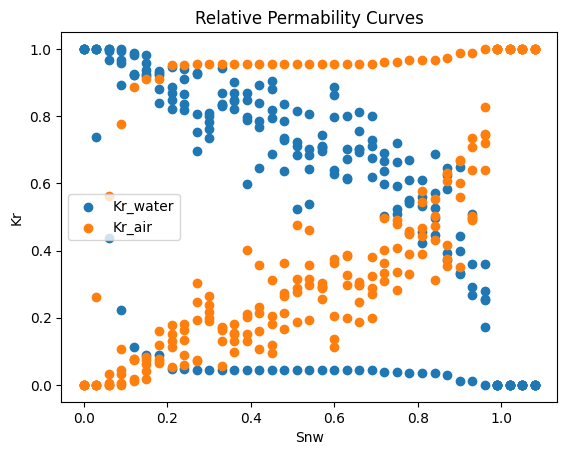

In [24]:
f = plt.figure()
ax = f.add_subplot(111)
ax.scatter(DF['Snwp'],DF['Kr_water'],label='Kr_water')
ax.scatter(DF['Snwp'],DF['Kr_air'],label='Kr_air')
ax.set_xlabel('Snw')
ax.set_ylabel('Kr')
ax.set_title('Relative Permability Curves')
ax.legend()
plt.show()

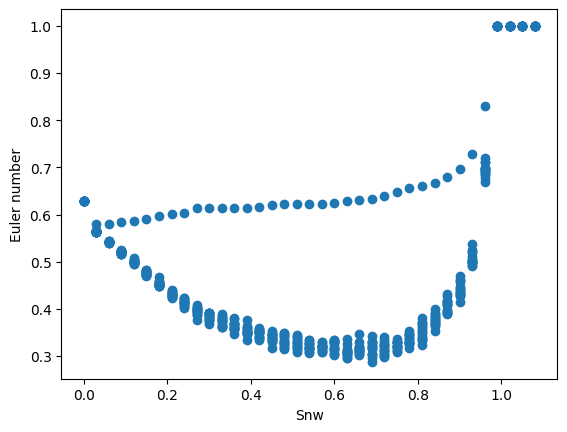

In [9]:
f = plt.figure()
ax = f.add_subplot(111)
ax.scatter(DF['Snwp'],DF['chi_norm'])
ax.set_xlabel('Snw')
ax.set_ylabel('Euler number')
plt.show()

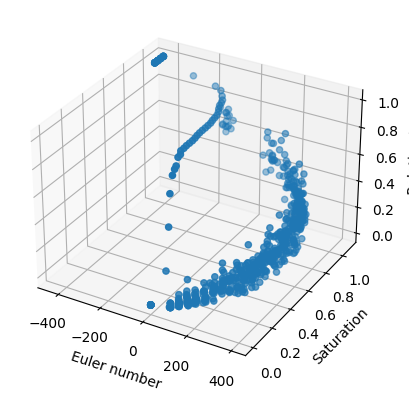

In [10]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(DF['chi'], DF['Snwp'],DF['Kr_air'])
ax.set_xlabel('Euler number')
ax.set_ylabel('Saturation')
ax.set_zlabel('Relative k')
plt.show()

#### Original algorithm

In [35]:

#%%
############### relative perm simulation ###################
st = op.algorithms.StokesFlow(network=pn)
st.setup(phase=water)
# in boundary front water saturation is 1
st.set_value_BC(pores=pn.pores('top'), values=1)
st.set_value_BC(pores=pn.pores('bottom'), values=0)
st.run()
Q_abs_water = st.rate(pores=pn.pores('top'))

air.update(ip.results(Snwp=0.20))
val = np.amin(phys_water['throat.hydraulic_conductance'])/1000

### cal of relative k of water ###
phys_water.regenerate_models()  # Regenerate phys2 to reset any calculation done above
Q_water = []  # Initialize a list to hold data
#stokes flow for water
for s in np.arange(0, 1.1, 0.1):  # Loop through saturations
    # 1: Update air object with occupancy at given saturation
    air.update(ip.results(Snwp=s))
    # 2: Overwrite water's hydraulic conductance in air-filled locations
    phys_water['throat.hydraulic_conductance'][air['throat.occupancy']] = val
    # 3: Re-run flow problem
    st.run()
    # 4: Compute flow through inlet phase and append to data
    Q_water.append(st.rate(pores=pn.pores('top')))
    phys_water.regenerate_models()


### cal of relative k of air ###
phys_water.regenerate_models()
phys_air.regenerate_models()
Q_air=[]
#stokes flow for air
st_a = op.algorithms.StokesFlow(network=pn)
st_a.setup(phase=air)
st_a.set_value_BC(pores=pn.pores('top'), values=1)
st_a.set_value_BC(pores=pn.pores('bottom'), values=0)
st_a.run()
Q_abs_air=st_a.rate(pores=pn.pores('top'))
for s in np.arange(0, 1.1, 0.1):  # Loop through saturations
    # 1: Update air object with occupancy at given saturation
    air.update(ip.results(Snwp=s))
    # 2: Overwrite air's hydraulic conductance in water-filled locations
    phys_air['throat.hydraulic_conductance'][~air['throat.occupancy']] = val
    # 3: Re-run flow problem
    st_a.run()
    # 4: Compute flow through inlet phase and append to data
    Q_air.append(st_a.rate(pores=pn.pores('top')))
    phys_air.regenerate_models()


#%%
##################### calculate euler characteristicsc #####################
chi_arr = []
for s in 1e-01*np.arange(0,11):
    # update the occupancy of pores and throat given saturation
    # True indicates air occupancy
    # air saturation is 0.25
    occupancies=ip.results(Snwp=s)
    air.update(ip.results(Snwp=s))
    
    ### Euler characteristics calculation - snwp = 0.25 ###
    # \chi = n1-n2+n3
    # n1: pores filled with air
    # n2: throats connected pores with air. Throats are inside a redundant loop
    # n3: throats connected pores with water. Isolated throat with air
    
    n1 = np.sum(air['pore.occupancy']*1)
    # air filled throat
    fill_t = np.where(air['throat.occupancy']==True)[0]
    # throat connected pore
    n2 = 0
    n3 = 0
    
    for index in fill_t:
        conn_pore = pn['throat.conns'][index]
        if n2_cal(conn_pore,air['pore.occupancy']):
            n2+=1
        
        if n3_cal(conn_pore,air['pore.occupancy']):
            n3+=1
    # chi = n1-n2+n3
    chi_arr.append(n1-n2+n3)

# DF['chi_norm'] = (DF['chi']-chi_max)/(chi_min-chi_max)

chi_arr = np.array(chi_arr)
chi_arr= (chi_arr - chi_max)/(chi_min-chi_max)

#%% 
####################### visualization #########################


data = {'Snwp':np.arange(0, 1.1, 0.1),'Kr_water':np.hstack(Q_water/Q_abs_water),'Kr_air':np.hstack((Q_air/Q_abs_air))} 
DF=pd.DataFrame(data)
DF



,Snwp,Kr_water,Kr_air
0,0.0,1.000000e+00,3.572561e-09
1,0.1,2.229730e-01,7.770271e-01
2,0.2,4.713609e-02,9.528640e-01
3,0.3,4.367542e-02,9.563247e-01
4,0.4,4.367542e-02,9.563247e-01
5,0.5,4.367542e-02,9.563247e-01
6,0.6,4.367542e-02,9.563247e-01
7,0.7,4.367542e-02,9.563247e-01
8,0.8,3.405306e-02,9.659471e-01
9,0.9,1.189527e-02,9.881049e-01


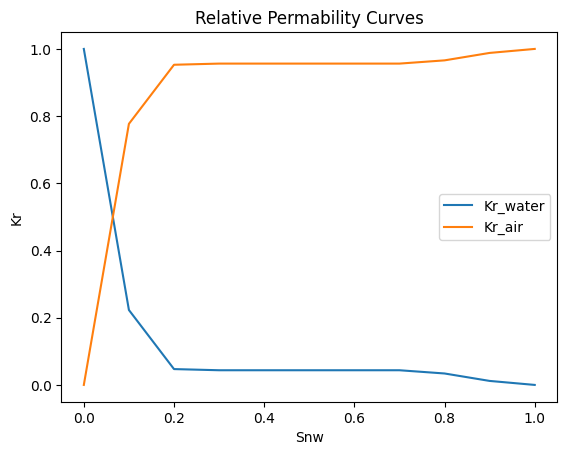

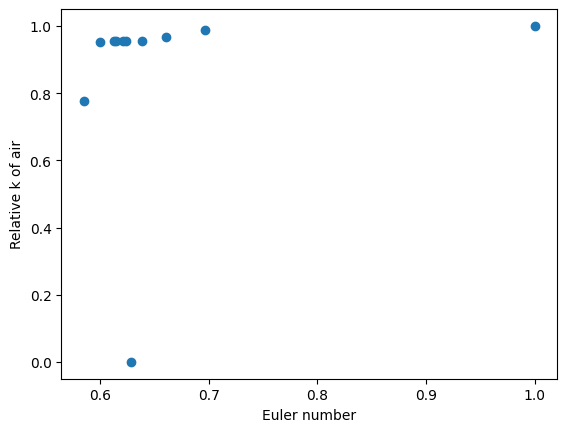

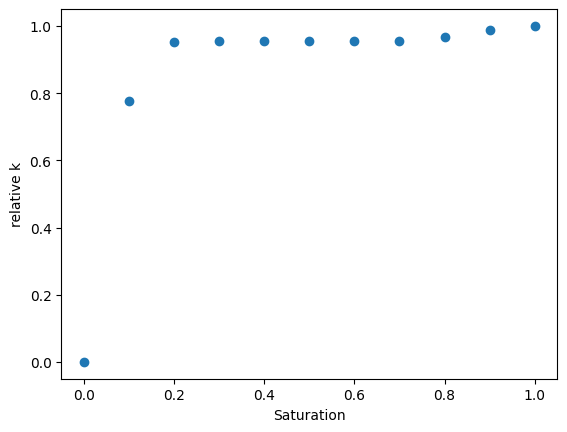

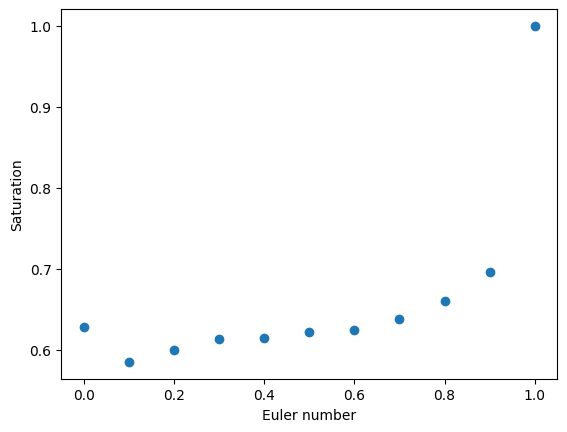

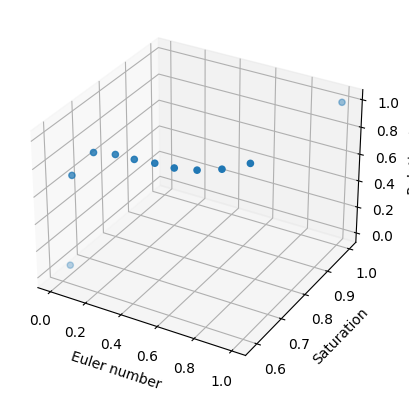

In [36]:
# relative perm and saturation curve
f = plt.figure()
ax = f.add_subplot(111)
ax.plot(DF['Snwp'],DF['Kr_water'],label='Kr_water')
ax.plot(DF['Snwp'],DF['Kr_air'],label='Kr_air')
ax.set_xlabel('Snw')
ax.set_ylabel('Kr')
ax.set_title('Relative Permability Curves')
ax.legend()
plt.show()
#f.savefig('fig/rel-k-gaswater.png')

f = plt.figure()
plt.scatter(chi_arr,DF['Kr_air'])
plt.ylabel('Relative k of air')
plt.xlabel('Euler number')
plt.show()
#f.savefig('fig/chi-k_air.png')


# saturation vs relative k #
f = plt.figure()
plt.scatter(1e-01*np.arange(0,11),DF['Kr_air'])
plt.xlabel('Saturation')
plt.ylabel('relative k')
plt.show()
#f.savefig('fig/s-k_air.png')

# Euler versus saturation #
f = plt.figure()
plt.scatter(1e-01*np.arange(0,11),chi_arr)
plt.xlabel('Euler number')
plt.ylabel('Saturation')
plt.show()
#f.savefig('fig/chi-s.png')



### 3D plot ###
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(1e-01*np.arange(0,11),chi_arr,DF['Kr_air'])
ax.set_xlabel('Euler number')
ax.set_ylabel('Saturation')
ax.set_zlabel('Relative k')
plt.show()
#fig.savefig('fig/3D.png')
# %%